In [388]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [389]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [390]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [391]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [392]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [393]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [394]:
# Assign the measurement class to a variable called `Measurement` and
measurement = Base.classes.measurement

# assign the station class to a variable called `Station`
station = Base.classes.station


In [395]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [396]:
# Find the most recent date in the data set.
#This creates a variable to store the most recent date using func.max on the measurement date to find the max date and scalar to execute and return the value
most_recent_date = session.query(func.max(measurement.date)).scalar()

#Display the result
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


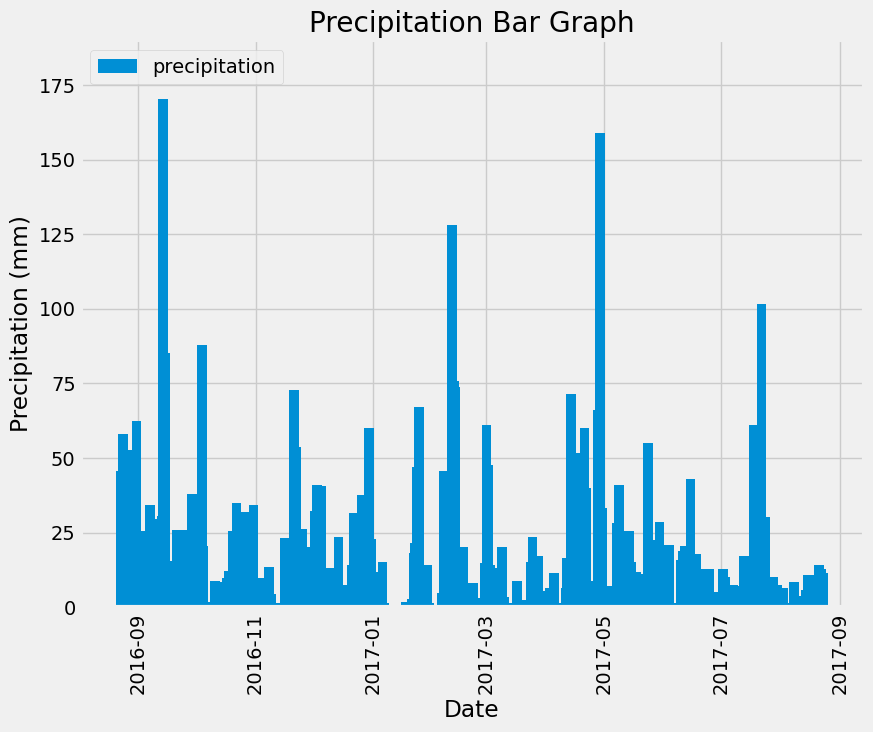

In [397]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
#this code converts the most recent date from YYYY-MM-DD format to datetime format for easier manipulation
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
#this code takes the most recent date, and subtracts 365 days to create a variable used for one year.
one_year = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#This code returns a query for the desired filtered range with the variables created above
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year).\
    filter(measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
#This creates a new data frame and converts the data in 'Date' to datetime format
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Sort the dataframe by date
# This code sorts the precipitation data frame in ascending order
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
#creation of bar graph inline with instructions, with slight formatting updates
plt.figure(figsize=(9,7))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=5)
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.ylim(0, 190)
plt.title('Precipitation Bar Graph')
plt.xticks(rotation=90)
plt.legend(['precipitation'], loc='upper left')
plt.show()

In [398]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Used the describe function to obtain summary statistics on the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

summary_statistics

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [399]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [400]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# This code retrieves the most active stations (based on count) and then prints in a desirable format
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()

# Print the results
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [401]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#This code obtains and prints the lowest, highest, and average temperature for USC00519281 and prints in a desirable output
most_active_station_id = 'USC00519281'
summary_statistics_USC00519281 = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).\
                     filter(measurement.station == most_active_station_id).all()

# Print the results
lowest_temp, highest_temp, avg_temp = summary_statistics_USC00519281[0]
print(f"Lowest Temperature: {lowest_temp} °C")
print(f"Highest Temperature: {highest_temp} °C")
print(f"Average Temperature: {avg_temp} °C")

Lowest Temperature: 12.2 °C
Highest Temperature: 29.4 °C
Average Temperature: 22.03582251082252 °C


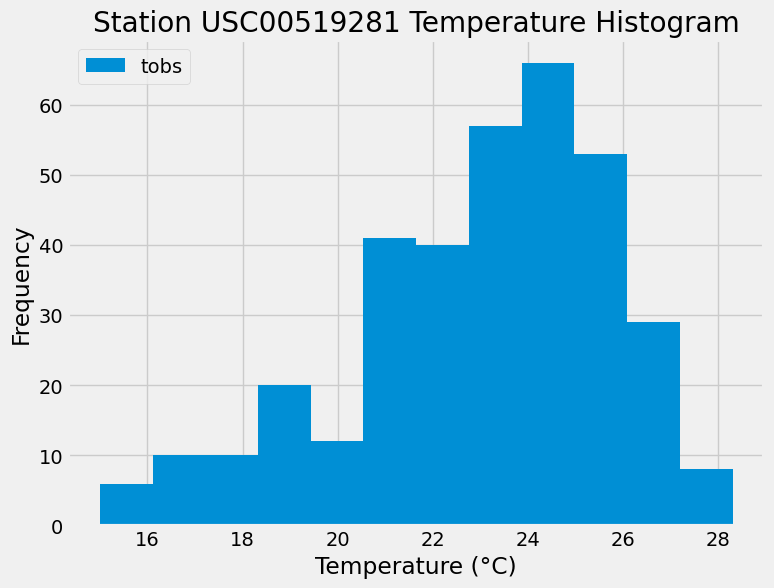

In [402]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#This code filters for the most recent year of data for USC00519281 
most_active_station_id_temperature = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id,
           measurement.date >= one_year,
           measurement.date <= most_recent_date).all()

#Created DataFrame
# This code creates a dataframe to be able to be used for the histogram
most_active_station_id_temperature_df = pd.DataFrame(most_active_station_id_temperature, columns=['Temperature'])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(most_active_station_id_temperature_df['Temperature'], bins=12)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Station USC00519281 Temperature Histogram')
plt.legend(['tobs'], loc='upper left')
plt.show()

# Close Session

In [403]:
# Close Session
session.close()
